# Fine-tuning `google/gemma-7b-it` using PEFT QLoRA

## Purpose
This notebook demonstrates the fine-tuning of the `google/gemma-7b-it` language model using **PEFT (Parameter-Efficient Fine-Tuning)** with **QLoRA** (Quantized Low Rank Adaptation). The fine-tuned model is trained on a custom dataset stored in Google Drive, and evaluation metrics such as training loss and evaluation loss are tracked and visualized. The final model is saved, and evaluation results are displayed for further analysis.

## Overview

1. **Declaration of global variables**:
  - Required libraries such as `peft`, `bitsandbytes`, `transformers`, and `trl` are installed.
   - Tokens for authentication (e.g., Hugging Face API tokens) are retrieved, and file paths for the dataset, output, and logs are defined.
   - Declaration of global variables

2. **Dataset Preparation**:
   - A CSV file containing the fine-tuning dataset is loaded into a Pandas DataFrame.
   - The dataset is split into training and evaluation sets using an 90/10 split, and the data is tokenized to create PyTorch tensors.
   - A custom dataset class (`LlmDataset`) is implemented to tokenize the text data and prepare the input tensors for training.
   - The tokenizer is also loaded, and padding settings are adjusted.

3. **Script Arguments and Configuration**:
   - A `ScriptArguments` class is defined to configure various hyperparameters for training, including batch sizes, learning rate, maximum sequence length, and training steps.
   - The **LoraConfig** is defined to set parameters for the fine-tuning process, such as `lora_alpha`, `lora_dropout`, and the target modules for LoRA.

4. **Loading the Model**:
   - The `google/gemma-7b-it` model is loaded from Hugging Face using the provided token, with quantization enabled (4-bit quantization using `bnb_4bit_quant_type="nf4"`).
   

5. **Training the Model**:
   - **SFTTrainer** (from the `trl` library) is used to train the model, incorporating gradient accumulation, checkpointing, and mixed precision training (fp16/bf16).
   - The model is trained over 1000 steps with evaluation happening every 100 steps.

6. **Visualizing Training and Evaluation Loss**:
   - Matplotlib is used to plot the training and evaluation loss over the steps to visually assess the model's performance during fine-tuning.

7. **Evaluating the Model**:
   - After training, the model is evaluated on the evaluation dataset, and the results are printed for analysis.






## 1. Declaration of global variables

In [1]:
!pip install peft
!pip install bitsandbytes transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [5]:
import torch
from google.colab import userdata

hface_read_token = userdata.get('hface-read-token')
dataset_file_path = '/content/drive/MyDrive/Colab Notebooks/finetuning-gemma/dataset/finetuning-dataset-gemma7b-it.csv'
output_dir = '/content/drive/MyDrive/Colab Notebooks/finetuning-gemma/output/'
logs_dir = '/content/drive/MyDrive/Colab Notebooks/finetuning-gemma/logs/'
model_id = "google/gemma-7b-it"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### 2. Dataset preparation

In [6]:
import pandas as pd

df = pd.read_csv(dataset_file_path, header=None)
finetuning_prompt_df = pd.DataFrame(df.iloc[:, 4])
finetuning_prompt_df.columns = ['prompt']

print(finetuning_prompt_df.head())

                                              prompt
0  <bos><start_of_turn>user ¿Quiénes están obliga...
1  <bos><start_of_turn>user ¿Qué ingresos deben d...
2  <bos><start_of_turn>user ¿Qué se entiende por ...
3  <bos><start_of_turn>user ¿Cuándo los residente...
4  <bos><start_of_turn>user ¿Qué diferencia hay e...


In [7]:
from sklearn.model_selection import train_test_split
training_df, eval_df = train_test_split(finetuning_prompt_df, test_size=0.1, random_state=42)

print(training_df.head())
print(len(training_df))

print(eval_df.head())
print(len(eval_df))

                                                 prompt
210   <bos><start_of_turn>user ¿Cómo se distribuirán...
1803  <bos><start_of_turn>user ¿Cómo se calcula la p...
2013  <bos><start_of_turn>user ¿Qué deducciones pued...
296   <bos><start_of_turn>user ¿Cómo se determina la...
1565  <bos><start_of_turn>user Indicar cuándo se deb...
2425
                                                 prompt
368   <bos><start_of_turn>user Definir qué se consid...
1418  <bos><start_of_turn>user ¿Cómo se calcula la r...
1765  <bos><start_of_turn>user ¿Pueden los contribuy...
1419  <bos><start_of_turn>user ¿Cómo deben calcular ...
1452  <bos><start_of_turn>user ¿Qué deberá hacer el ...
270


In [8]:
from torch.utils.data import Dataset

class LlmDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        encoded_inputs = self.tokenizer(
            row['prompt'],                # El texto a tokenizar
            padding='max_length',         # Padding a la longitud máxima
            max_length=self.max_length,   # Longitud máxima de los tokens
            truncation=True,              # Truncar si es necesario
            return_tensors='pt'           # Devolver como tensores de PyTorch
        )

        return {
            'input_ids': encoded_inputs['input_ids'].squeeze(0),
            'labels': encoded_inputs['input_ids'].squeeze(0),
            'attention_mask': encoded_inputs['attention_mask'].squeeze(0)
        }

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id, token=hface_read_token)
tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [10]:
training_dataset = LlmDataset(training_df, tokenizer, max_length=1459)
print(training_dataset[0])

{'input_ids': tensor([     1,      1,      1,  ...,   5260, 235265,      1]), 'labels': tensor([     1,      1,      1,  ...,   5260, 235265,      1]), 'attention_mask': tensor([0, 0, 0,  ..., 1, 1, 1])}


In [11]:
eval_dataset = LlmDataset(eval_df, tokenizer, max_length=1459)
print(eval_dataset[0])

{'input_ids': tensor([     1,      1,      1,  ...,   3136, 235265,      1]), 'labels': tensor([     1,      1,      1,  ...,   3136, 235265,      1]), 'attention_mask': tensor([0, 0, 0,  ..., 1, 1, 1])}


### 3. Script Arguments and Configuration

In [12]:
from dataclasses import dataclass, field
from typing import Optional

@dataclass
class ScriptArguments:
    """
    These arguments vary depending on how many GPUs you have, what their capacity and features are, and what size model you want to train.
    """
    per_device_train_batch_size: Optional[int] = field(default=4)
    per_device_eval_batch_size: Optional[int] = field(default=1)
    gradient_accumulation_steps: Optional[int] = field(default=4)
    learning_rate: Optional[float] = field(default=2e-4)
    max_grad_norm: Optional[float] = field(default=0.3)
    weight_decay: Optional[int] = field(default=0.001)
    lora_alpha: Optional[int] = field(default=16)
    lora_dropout: Optional[float] = field(default=0.1)
    lora_r: Optional[int] = field(default=8)
    max_seq_length: Optional[int] = field(default=1459)
    fp16: Optional[bool] = field(default=False)
    bf16: Optional[bool] = field(default=True)
    packing: Optional[bool] = field(default=True)
    gradient_checkpointing: Optional[bool] = field(default=True)
    use_flash_attention_2: Optional[bool] = field(default=False)
    optim: Optional[str] = field(default="paged_adamw_32bit")
    lr_scheduler_type: str = field(default="constant")
    max_steps: int = field(default=1000)
    warmup_ratio: float = field(default=0.03)
    save_steps: int = field(default=100)
    output_dir: str = field(default=output_dir)
    logging_dir: str = field(default=logs_dir)
    logging_steps: int = field(default=10)
    evaluation_strategy: str = field(default="steps")
    eval_steps: int = field(default=100)
    report_to: str = field(default="tensorboard")

In [13]:
from transformers import HfArgumentParser, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig

parser = HfArgumentParser(ScriptArguments)
script_args = parser.parse_args_into_dataclasses(args=[])[0]

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=script_args.lora_r,
    lora_alpha=script_args.lora_alpha,
    lora_dropout=script_args.lora_dropout,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=None
)

training_arguments = TrainingArguments(
    per_device_train_batch_size=script_args.per_device_train_batch_size,
    per_device_eval_batch_size=script_args.per_device_eval_batch_size,
    gradient_accumulation_steps=script_args.gradient_accumulation_steps,
    optim=script_args.optim,
    learning_rate=script_args.learning_rate,
    max_grad_norm=script_args.max_grad_norm,
    max_steps=script_args.max_steps,
    warmup_ratio=script_args.warmup_ratio,
    lr_scheduler_type=script_args.lr_scheduler_type,
    gradient_checkpointing=script_args.gradient_checkpointing,
    fp16=script_args.fp16,
    bf16=script_args.bf16,
    evaluation_strategy=script_args.evaluation_strategy,
    eval_steps=script_args.eval_steps,
    output_dir=output_dir,
    save_steps=script_args.save_steps,
    logging_steps=script_args.logging_steps,
    logging_dir=script_args.logging_dir,
    report_to=script_args.report_to
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 4. Loading the Model

In [14]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    token=hface_read_token
)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [15]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=training_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    packing=script_args.packing,
    tokenizer=tokenizer,
    max_seq_length=script_args.max_seq_length,
    num_of_sequences=1,
    chars_per_token=3.6
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': packing, max_seq_length, num_of_sequences, chars_per_token. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:195: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.

### 5. Training the Model

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
100,0.099800,0.093438
200,0.066400,0.075634
300,0.060800,0.065198
400,0.050000,0.064666
500,0.030100,0.064734
600,0.034200,0.061459
700,0.023600,0.066804
800,0.017800,0.072718
900,0.020600,0.070668
1000,0.017300,0.074419


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:619: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-66d648f9-2863c69475c578af0e3a60f1;6a3aaf96-ac2e-4e5b-8592-538e8b62b929)

Cannot access gated repo for url https://huggingface.co/google/gemma-7b-it/resolve/main/config.json.
Access to model google/gemma-7b-it is restricted. You must be authenticated to access it. - silently ignoring the lookup for the file config.json in google/gemma-7b-it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:218: UserWarning: Could not find a config file in google/gemma-7b-it - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is

TrainOutput(global_step=1000, training_loss=0.08139002846181392, metrics={'train_runtime': 11654.8865, 'train_samples_per_second': 1.373, 'train_steps_per_second': 0.086, 'total_flos': 1.0879474838526566e+18, 'train_loss': 0.08139002846181392, 'epoch': 6.589785831960461})

### 6. Visualizing Training and Evaluation Loss

In [ ]:
metrics = trainer.state.log_history
print(metrics)

[{'loss': 3.3189, 'grad_norm': 2.7787487506866455, 'learning_rate': 0.0002, 'epoch': 0.06589785831960461, 'step': 10}, {'loss': 0.2742, 'grad_norm': 2.048593759536743, 'learning_rate': 0.0002, 'epoch': 0.13179571663920922, 'step': 20}, {'loss': 0.2314, 'grad_norm': 2.5160036087036133, 'learning_rate': 0.0002, 'epoch': 0.19769357495881384, 'step': 30}, {'loss': 0.1494, 'grad_norm': 2.296931505203247, 'learning_rate': 0.0002, 'epoch': 0.26359143327841844, 'step': 40}, {'loss': 0.1316, 'grad_norm': 1.4885828495025635, 'learning_rate': 0.0002, 'epoch': 0.32948929159802304, 'step': 50}, {'loss': 0.1185, 'grad_norm': 0.9664739370346069, 'learning_rate': 0.0002, 'epoch': 0.3953871499176277, 'step': 60}, {'loss': 0.1133, 'grad_norm': 1.3897104263305664, 'learning_rate': 0.0002, 'epoch': 0.4612850082372323, 'step': 70}, {'loss': 0.1045, 'grad_norm': 1.4849785566329956, 'learning_rate': 0.0002, 'epoch': 0.5271828665568369, 'step': 80}, {'loss': 0.1101, 'grad_norm': 1.362212896347046, 'learning_r

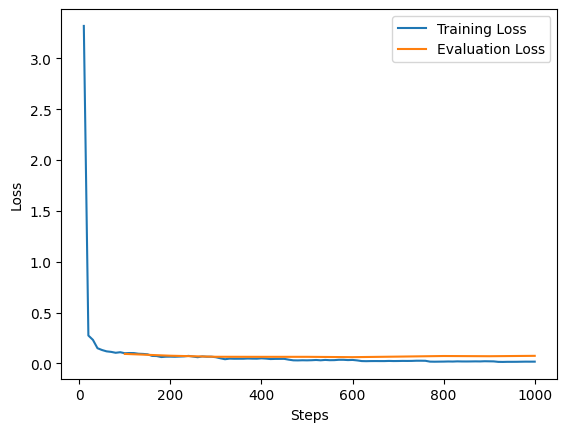

In [ ]:
import matplotlib.pyplot as plt

# Extract steps and corresponding losses, ensuring they have the same length
train_metrics = [x for x in metrics if "loss" in x]
steps = [x["step"] for x in train_metrics]
train_loss = [x["loss"] for x in train_metrics]

# Similarly for evaluation loss
eval_metrics = [x for x in metrics if "eval_loss" in x]
eval_steps = [x["step"] for x in eval_metrics]
eval_loss = [x["eval_loss"] for x in eval_metrics]

plt.plot(steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


### 7. Evaluating the Model

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.07441940903663635, 'eval_runtime': 62.0831, 'eval_samples_per_second': 4.349, 'eval_steps_per_second': 4.349, 'epoch': 6.589785831960461}
